In [1]:
import random
import numpy as np

SEED = 93
np.random.seed(SEED)
random.seed(SEED)

In [2]:
import torch

if torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [3]:
from sklearn.metrics import balanced_accuracy_score

def compute_accuracy(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"balanced_accuracy": balanced_accuracy_score(y_true=labels, y_pred=predictions)}

In [4]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {i: "{id} Star" for i in range(5)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
).to(device)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:
model.base_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [6]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [7]:
from datasets import load_dataset

data_dict = {
    "train": "yelp_train.parquet",
    "eval": "yelp_eval.parquet",
    "test": "yelp_test.parquet"
}

yelp_train_data = load_dataset("parquet", data_files=data_dict, split="train")
yelp_eval_data = load_dataset("parquet", data_files=data_dict, split="eval")
yelp_train_data

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 39980
})

In [8]:
from transformers import DataCollatorWithPadding, AutoTokenizer

BATCH = 8
GRADIENT_STEP = 2
LEARNING_RATE = 1e-4
EPOCHS = 4
LAMBDA = 0.01

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="yelp-distil-bert",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=GRADIENT_STEP,
    gradient_checkpointing=True,
    num_train_epochs=EPOCHS,
    weight_decay=LAMBDA,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_train_data,
    eval_dataset=yelp_eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy
)

results = trainer.train(resume_from_checkpoint = True)

/Users/shilongdai/PycharmProjects/Analysis/venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [9]:
model.eval()


def inference(text_batch):
    tokenized = tokenizer(text_batch, padding=True, truncation=True, return_tensors="pt").to(device)
    return model(**tokenized)


yelp_test = load_dataset("parquet", data_files=data_dict, split="test").remove_columns(['input_ids', 'attention_mask'])
yelp_test = yelp_test.map(lambda d: {"predicted": inference(d["text"]).logits.argmax(dim=1).tolist()}, batched=True, batch_size=16)
yelp_test

Dataset({
    features: ['text', 'label', 'predicted'],
    num_rows: 4998
})

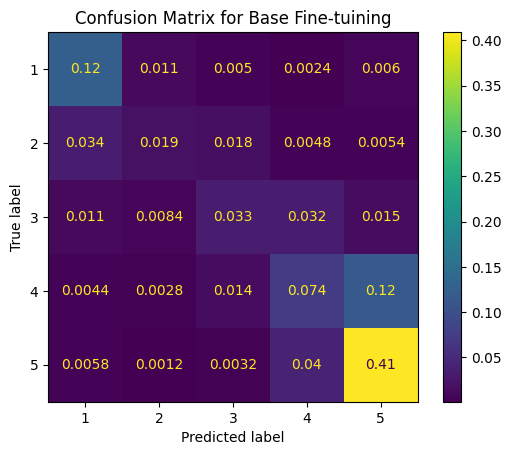

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=yelp_test["label"], 
                                        y_pred=yelp_test["predicted"], 
                                        display_labels=list(range(1, 6)), 
                                        normalize="all"
                                       )
plt.title("Confusion Matrix for Base Fine-tuining")
plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_true=yelp_test["label"], 
                            y_pred=yelp_test["predicted"], 
                            target_names=["%d Star" % i for i in range(1, 6)]))

              precision    recall  f1-score   support

      1 Star       0.69      0.84      0.76       743
      2 Star       0.45      0.23      0.31       405
      3 Star       0.45      0.33      0.38       498
      4 Star       0.48      0.35      0.41      1056
      5 Star       0.74      0.89      0.81      2296

    accuracy                           0.66      4998
   macro avg       0.56      0.53      0.53      4998
weighted avg       0.63      0.66      0.63      4998



In [12]:
round(balanced_accuracy_score(yelp_test["label"], yelp_test["predicted"]), 2)

0.53